In [53]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Library for scaling and PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# To create a pipline
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# for k-means clustering
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
from sklearn.metrics import silhouette_score

# to see data on world map we use this library
import plotly.express as px

# for deployment
import joblib

In [3]:
# Lets Load the Data file

data = pd.read_csv(r"D:\UNSUPERVISED LEARNING\CASE STUDY\USL Case study\Country-data.csv")

In [4]:
# Lets explore the data file
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


# LETS EXPLORE THE DATASET

In [5]:
data.shape

(167, 10)

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
child_mort,167.0,38.270060,40.328931,2.6000,8.250,19.30,62.10,208.00
exports,167.0,41.108976,27.412010,0.1090,23.800,35.00,51.35,200.00
health,167.0,6.815689,2.746837,1.8100,4.920,6.32,8.60,17.90
imports,167.0,46.890215,24.209589,0.0659,30.200,43.30,58.75,174.00
income,167.0,17144.688623,19278.067698,609.0000,3355.000,9960.00,22800.00,125000.00
inflation,167.0,7.781832,10.570704,-4.2100,1.810,5.39,10.75,104.00
life_expec,167.0,70.555689,8.893172,32.1000,65.300,73.10,76.80,82.80
total_fer,167.0,2.947964,1.513848,1.1500,1.795,2.41,3.88,7.49
gdpp,167.0,12964.155689,18328.704809,231.0000,1330.000,4660.00,14050.00,105000.00


Inference – Summary Statistics

The dataset contains 167 countries and 9 numeric indicators covering child mortality, trade (exports/imports), health expenditure, income, inflation, life expectancy, fertility and GDP per capita.

Variables like income and gdpp have very high standard deviations compared to their means, indicating huge inequality in economic development across countries.

Child mortality ranges from about 2.6 to 208 per 1,000 live births, again showing extreme variation in basic health outcomes.

Life expectancy spans roughly from 32 to 83 years, implying that some countries have life conditions comparable to high-income nations while others are in severe distress.

Inflation can even be negative in some countries (deflation) and goes up to above 100%, indicating macroeconomic instability in several cases.

Overall, the descriptive statistics confirm that the dataset captures a wide spectrum from very poor to very rich countries, which is ideal for clustering.

### Correlation HeatMap

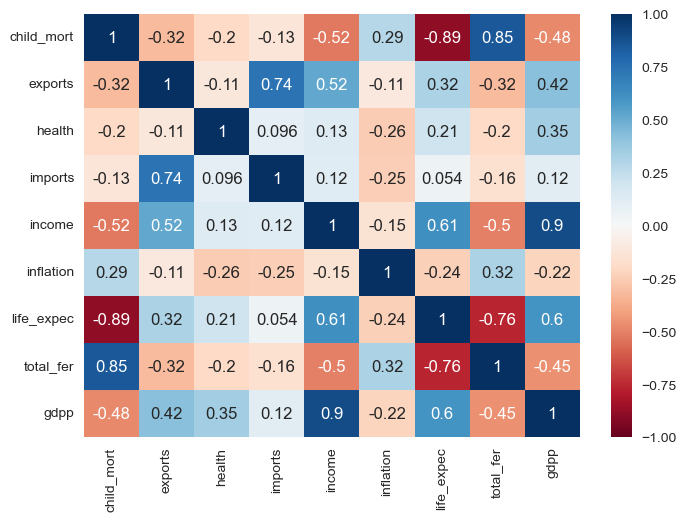

In [7]:
sns.heatmap(data.corr(numeric_only=True),annot=True,vmin=-1,cmap='RdBu')
plt.show()

Inference – Correlation Heatmap

Child mortality is strongly negatively correlated with life expectancy and gdpp and income, meaning that richer countries with higher life expectancy tend to have much lower child deaths.

Income and gdpp show a very strong positive correlation, consistent with both being measures of economic prosperity.

Exports and imports are positively related with income/gdpp, suggesting that richer countries are also more integrated into global trade.

Inflation has weak or moderate negative relationships with development indicators, indicating that very high inflation often coincides with weaker economies, but it is not the single dominant driver.

Overall, the correlations support the intuition that economic strength and trade openness are associated with better health outcomes and lower mortality, which is important for interpreting the clusters later.

## VISUALIZE THE DATA

In [9]:
# Before we begin visualization lets convert country to index as it is a reduncdant column

data.set_index('country',inplace=True)
data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


### UNIVARIATE ANALYSIS

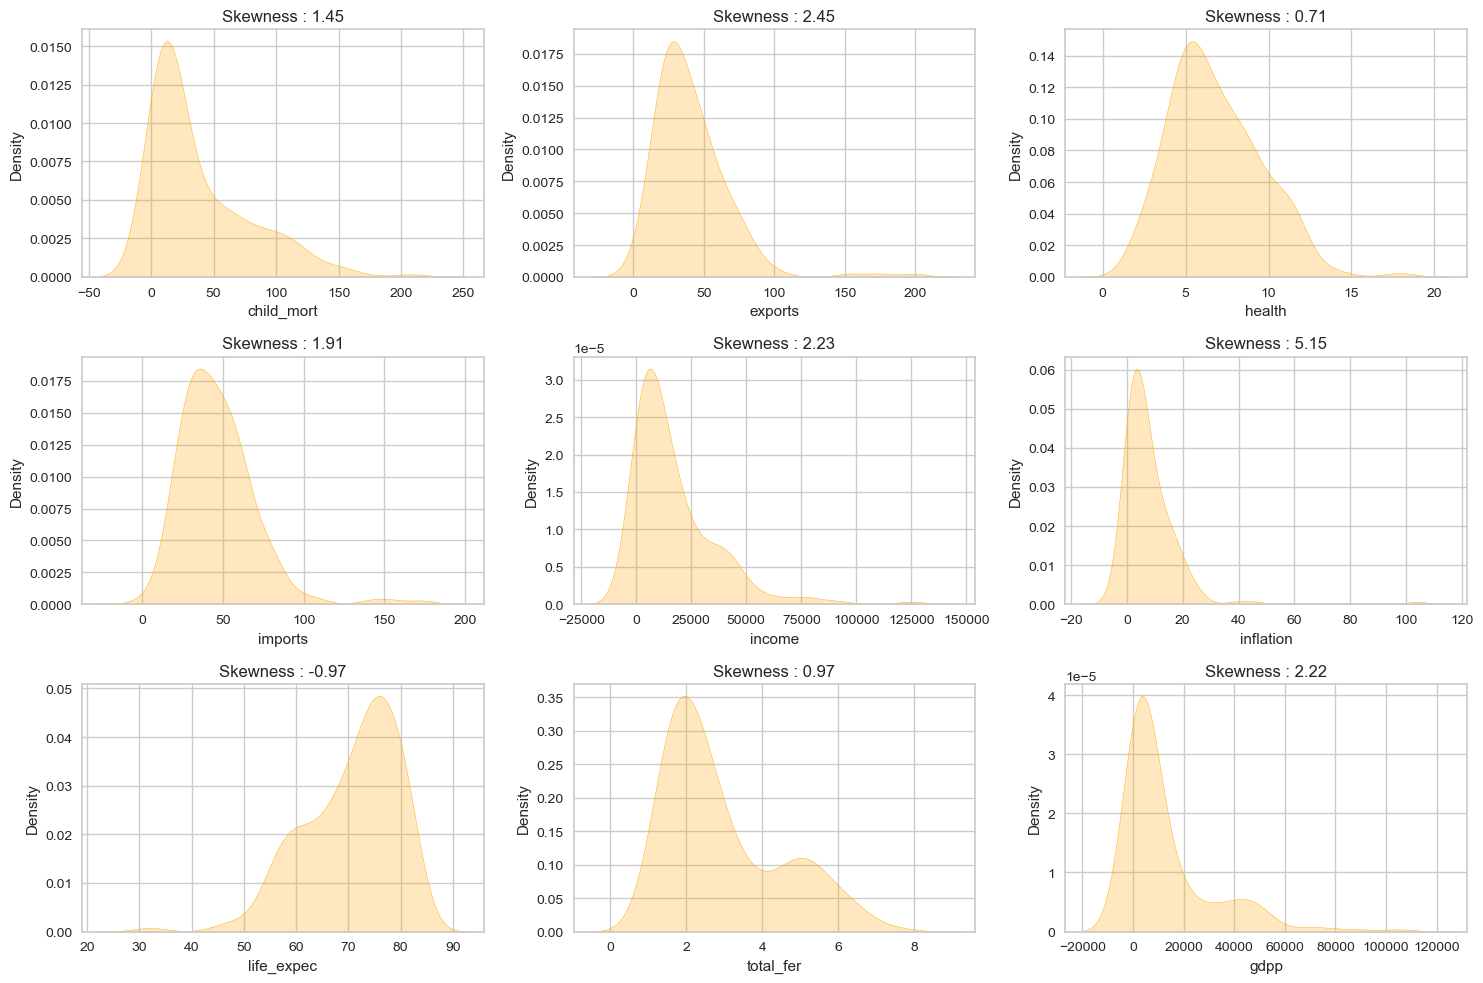

In [10]:
t=1
plt.figure(figsize=(15,10))
for i in data.columns:
    plt.subplot(3,3,t)
    sns.kdeplot(data=data,x=i,fill=True,color='orange')
    plt.title(f'Skewness : {round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

Inference – Distribution of Features (KDE)

Many variables such as income and gdpp are right-skewed, meaning a small number of countries are extremely rich while most have relatively low values.

Child mortality and total fertility are also skewed, with many countries having low to moderate values and a few with very high mortality and fertility.

Life expectancy is more concentrated towards the higher side (60–80 years) for many countries, but there is a tail of nations with very low life expectancy, indicating vulnerable populations.

This skewness tells us that outliers and extreme values exist and need to be handled carefully before clustering so they don’t dominate the distance calculations.

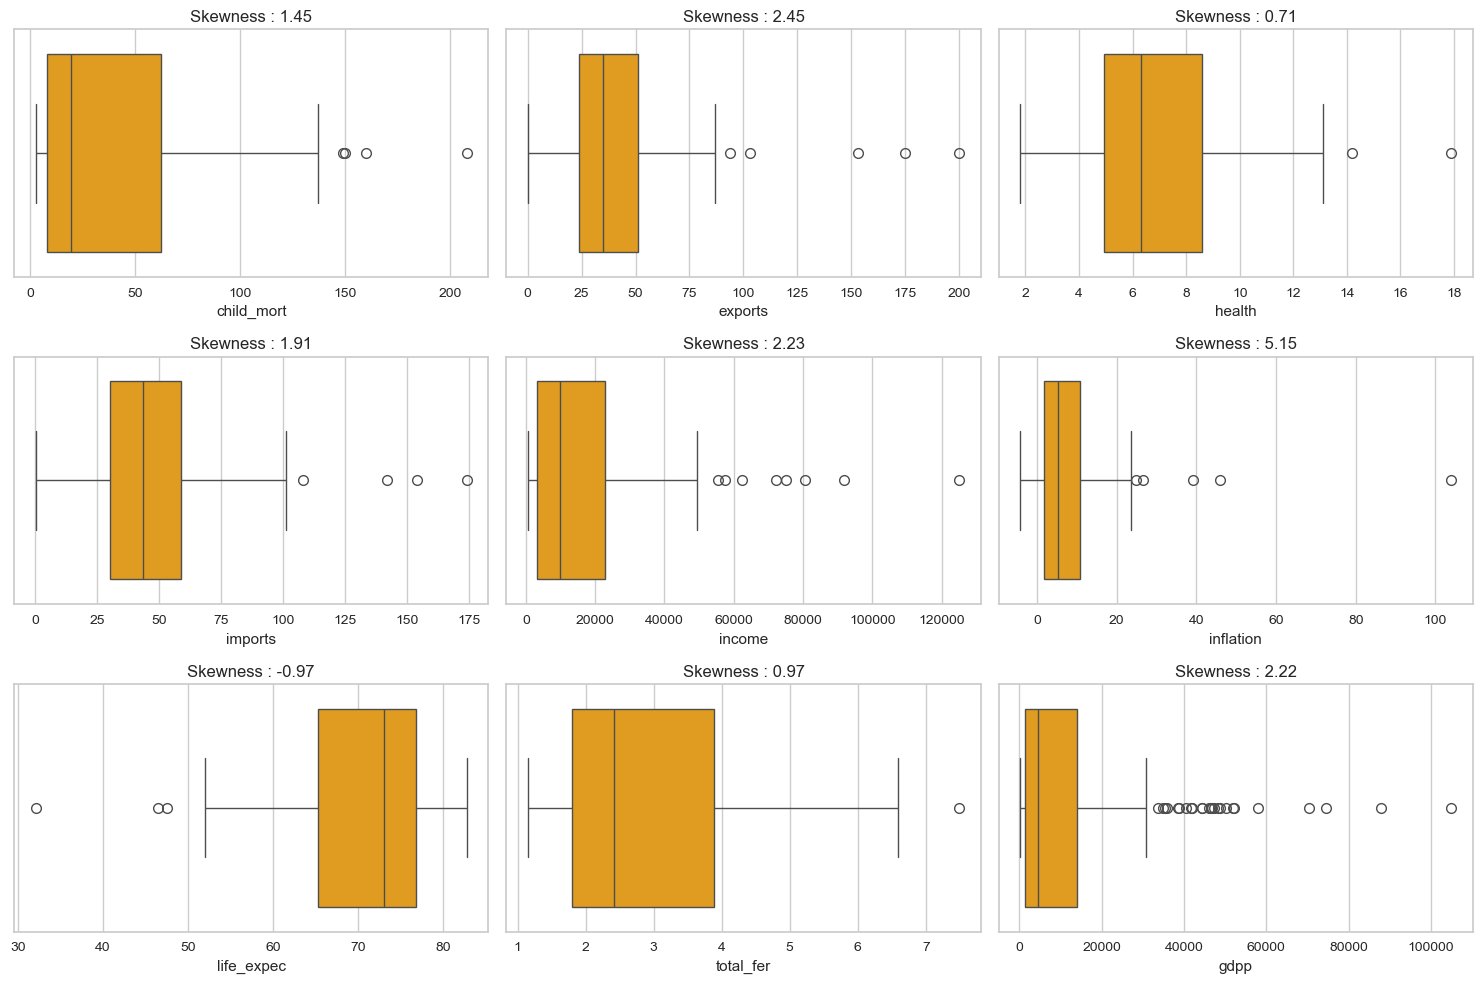

In [11]:
t=1
plt.figure(figsize=(15,10))
for i in data.columns:
    plt.subplot(3,3,t)
    sns.boxplot(data=data,x=i,color='orange')
    plt.title(f'Skewness : {round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

Inference – Outliers from Boxplots (Before Treatment)

Nearly all variables exhibit visible outliers, especially income, gdpp, inflation, and child mortality.

Economic variables show several extremely high values (very rich countries) that are far out of the typical range for most nations.

Similarly, child mortality has a few countries with exceptionally high mortality compared to the bulk.

These outliers could pull centroids towards them in K-means and distort the cluster structure, justifying the need for an outlier-treatment step.

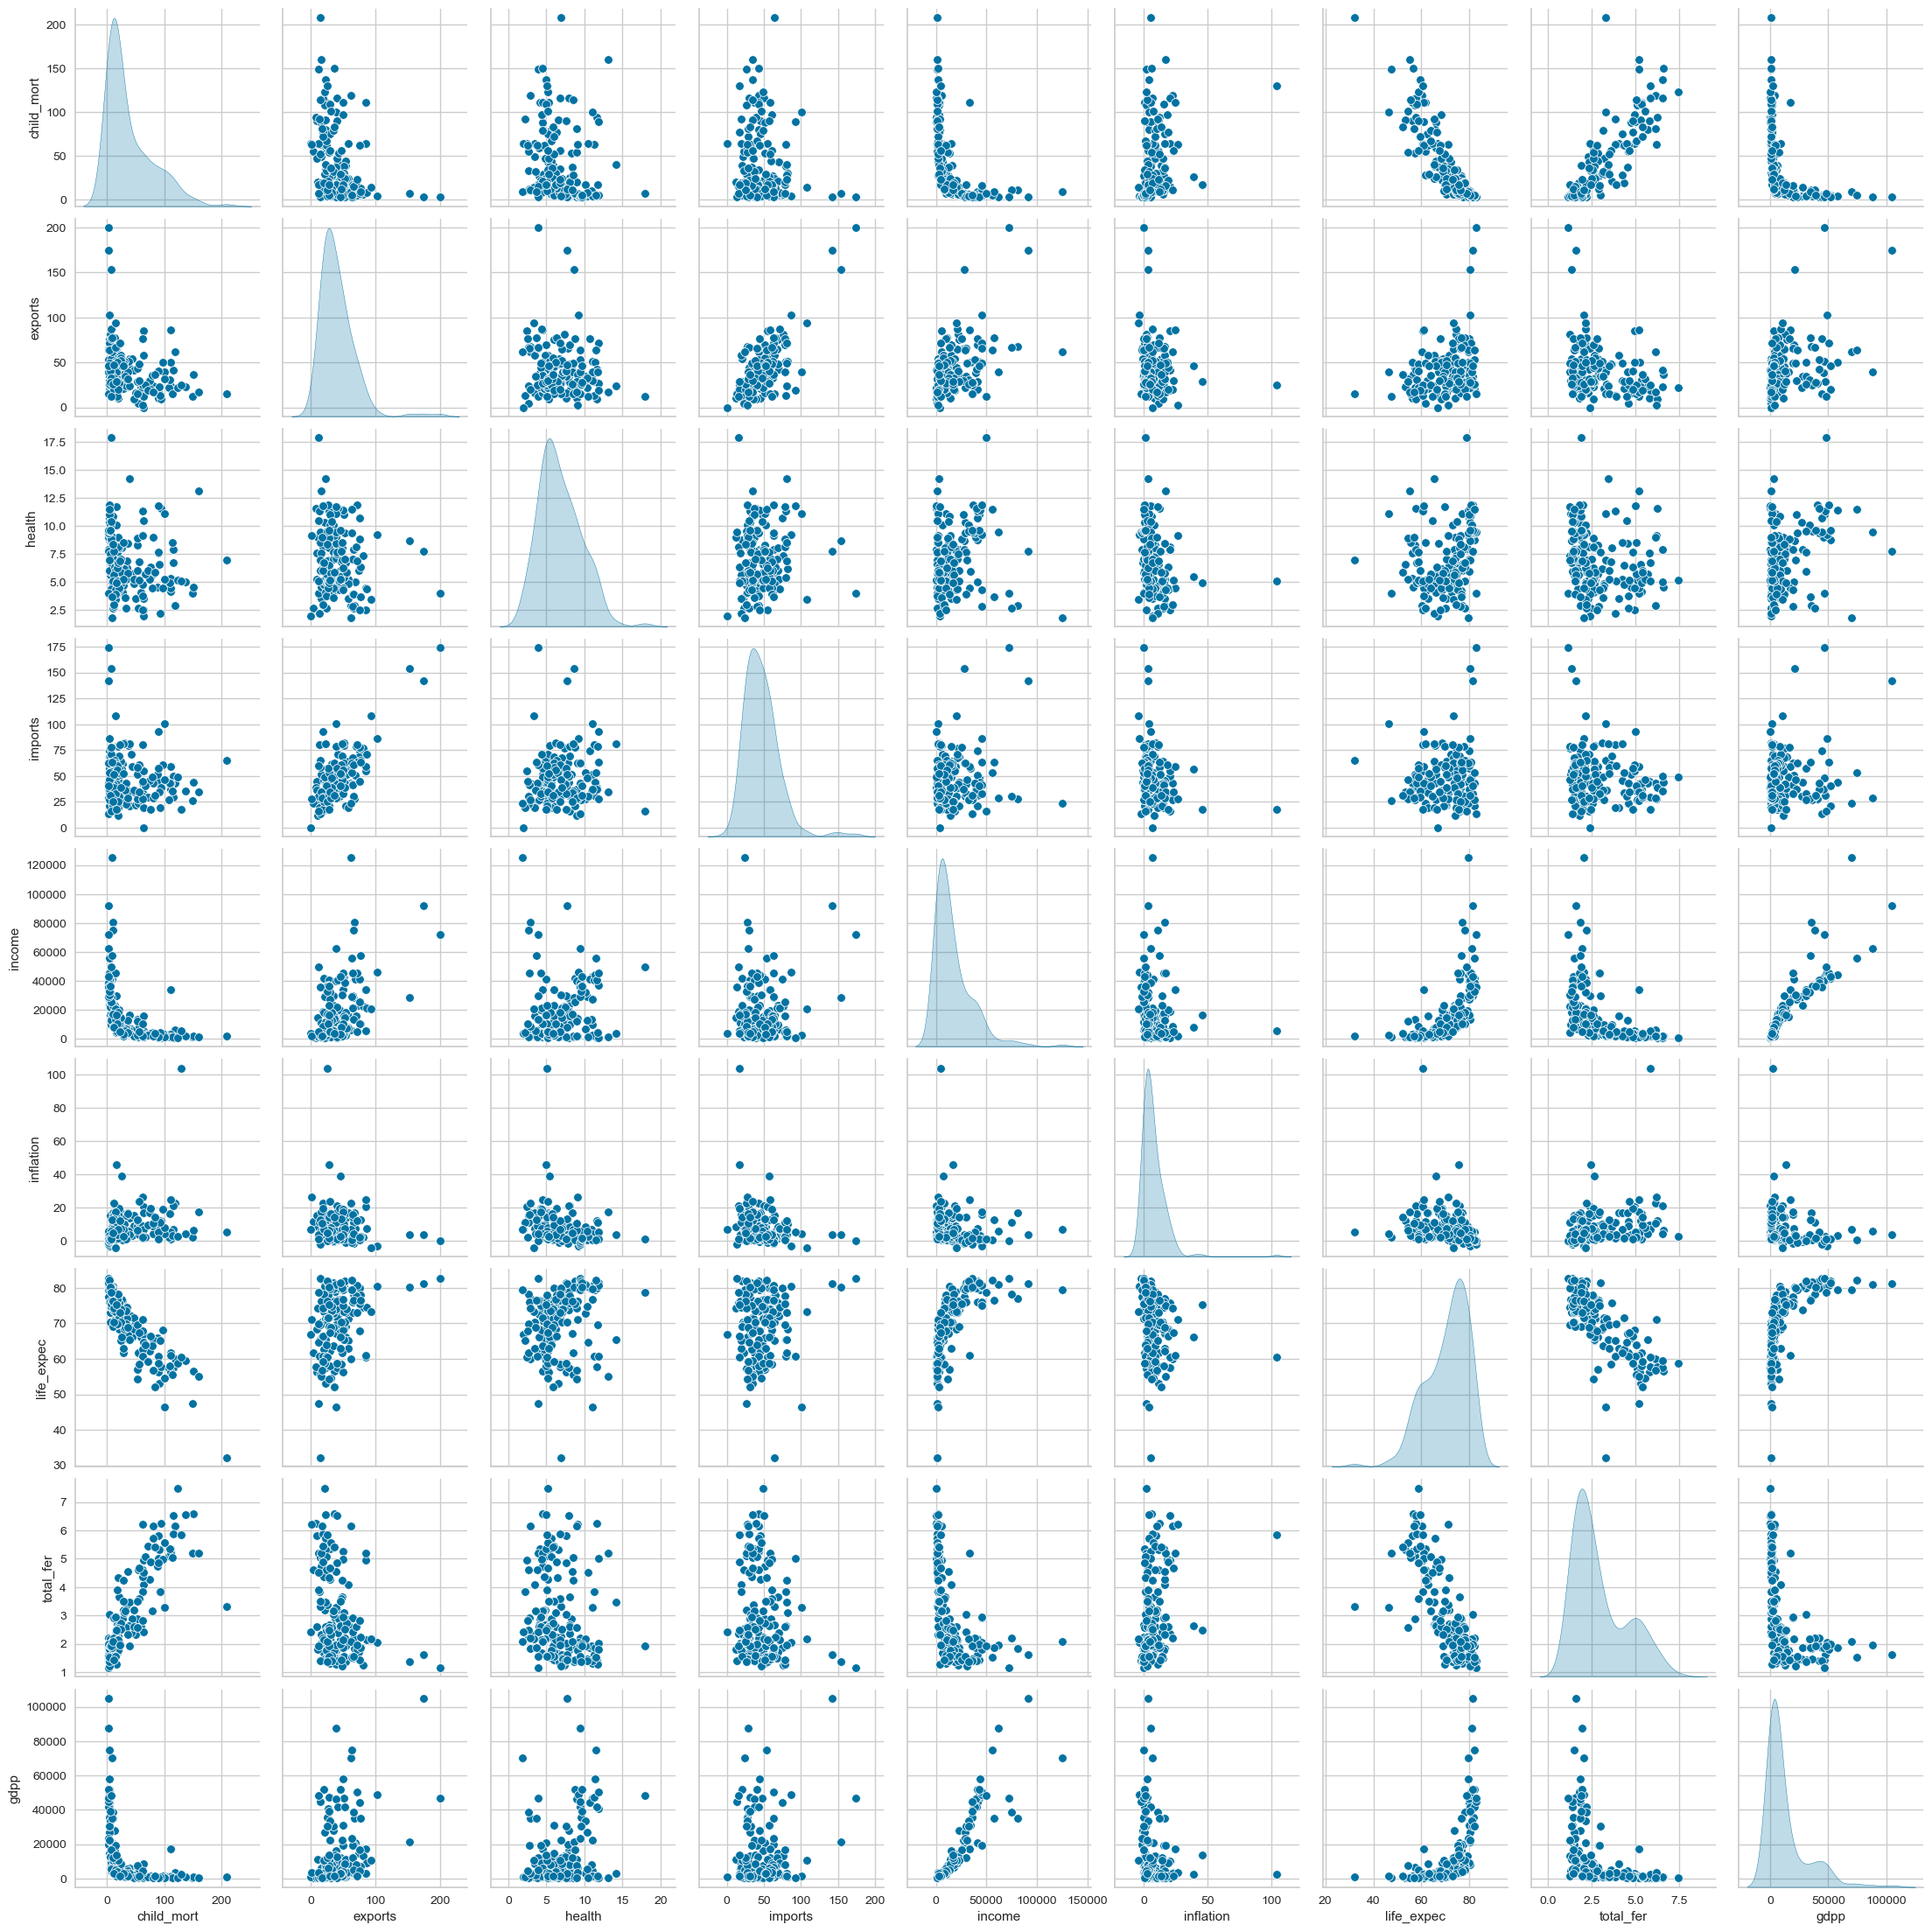

In [12]:
# MultiVariate Analysis 
sns.pairplot(data,diag_kind='kde')
plt.show()

Inference – Multivariate Relationships

The scatter plots show clear trends: countries with higher income/gdpp tend to have higher life expectancy, lower child mortality and lower fertility.

There is an inverse pattern between child mortality / fertility and gdpp / income, reinforcing the idea that economic development and basic health outcomes move together.

Some relationships look non-linear and there are visible clusters and bands, which suggests that clustering might capture meaningful groups of countries based on these patterns.

## PREPROCESSING

In [13]:
# Check for missing values
data.isnull().sum().sum()

# No missing values

np.int64(0)

Inference – Missing Values

There are no missing values in the dataset, so we do not need imputation.

This simplifies the preprocessing pipeline and ensures that all countries and features can be used directly for PCA and clustering.

In [14]:
# Lets treat the ouliers
# we will go with capping using IQR method
# In order to cap only the extreme ones lets keep whisker length= 2.5

for i in data.columns:
    q1,q3 = np.quantile(data[i],[0.25,0.75])
    iqr = q3-q1
    UL,LL = q3+2.5*iqr,q1-2.5*iqr
    data[i] = data[i].apply(lambda x:UL if x>UL else LL if x<LL else x)

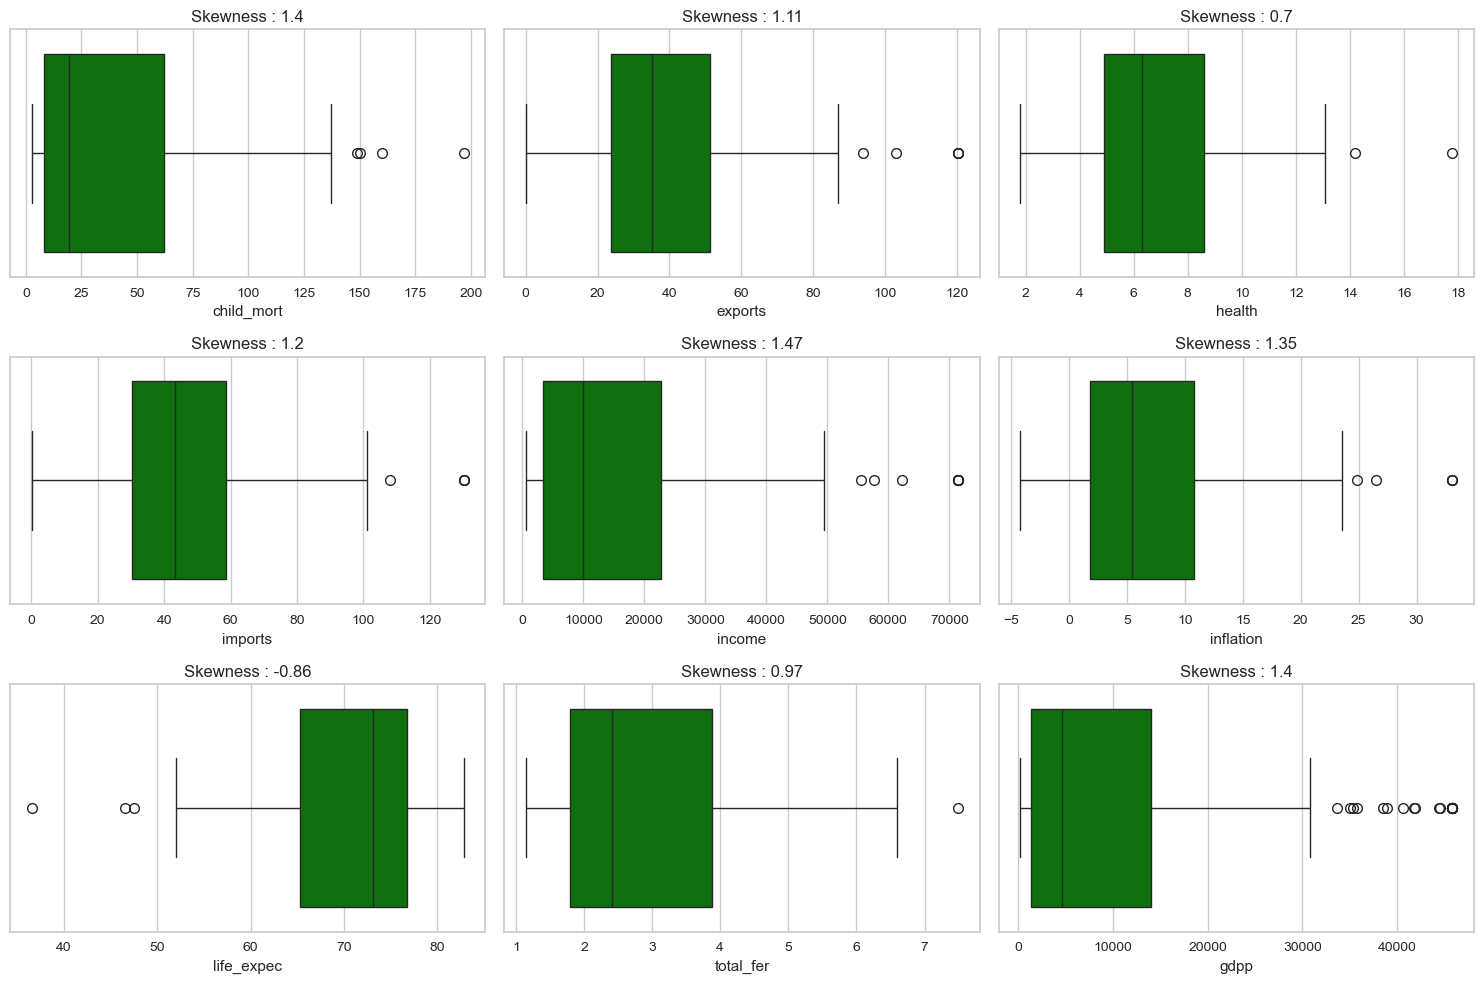

In [15]:
t=1
plt.figure(figsize=(15,10))
for i in data.columns:
    plt.subplot(3,3,t)
    sns.boxplot(data=data,x=i,color='green')
    plt.title(f'Skewness : {round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

Inference – After Outlier Treatment

The extreme outliers visible earlier have been capped using the IQR-based method, and the boxplots now show more compact ranges.

Skewness in some variables has reduced slightly, though the underlying economic inequality between countries is still visible (as expected).

By capping only the most extreme values (whisker length 2.5), we reduce the undue influence of outliers on distance-based methods like K-means without destroying the original ranking of countries.

In [16]:
# Lets apply PCA on the data before we proceed with clustering.
# Just to have better Visualization
# In PCA we need to pass Standardised data. 
# So lets import the functions from the Libraries

# Lets create an instance of scalling
scaler = StandardScaler()

# Also lets create an instance for PCA
pca = PCA(n_components=9,random_state=2)

# Lets create pipline for the above two processes

pipeline = Pipeline([('Scale',scaler),
                     ('PCA',pca)])

In [17]:
pipeline.fit(data)

Pipeline(steps=[('Scale', StandardScaler()),
                ('PCA', PCA(n_components=9, random_state=2))])

In [18]:
pca

PCA(n_components=9, random_state=2)

In [19]:
pca.explained_variance_ratio_.cumsum()


# At n_components = 5 we are able to explain ~ 95% variance which is good enough 
# so  9-dimension data can be reduced to 5-Dimension in the above code
# so we have changed the value from 9 to 5 above

array([0.4758564 , 0.64300208, 0.77845398, 0.88018006, 0.94647697,
       0.96981892, 0.98571825, 0.99510744, 1.        ])

Inference – PCA Dimensionality Reduction

The first 5 principal components capture about 94–95% of the total variance, which is a very high proportion.

This means we can safely reduce from 9 original features to 5 components with minimal information loss.

Using PCA helps in two ways:

It decorrelates the variables (important because many original features are correlated).

It allows easier visualization of clusters (mainly on PC1 and PC2) while retaining most of the structure.

In [20]:
pca = PCA(n_components=5,random_state=2)

# Lets create pipline for the above two processes

pipeline = Pipeline([('Scale',scaler),
                     ('PCA',pca)])
pipeline.fit(data)

Pipeline(steps=[('Scale', StandardScaler()),
                ('PCA', PCA(n_components=5, random_state=2))])

In [21]:
pca

PCA(n_components=5, random_state=2)

In [22]:
final_data = pipeline.transform(data)


In [23]:
final_data

array([[-3.04363665e+00, -2.01155292e-01,  9.51322351e-01,
         7.93444721e-01, -6.80001185e-03],
       [ 4.23415208e-01, -3.71462539e-01,  1.71749065e-01,
        -1.35358051e+00,  8.86229412e-02],
       [-4.04683884e-01, -4.40311949e-01, -1.63677511e+00,
        -5.73008378e-01,  3.97118511e-01],
       [-3.15006302e+00,  1.42528284e+00, -1.78498242e+00,
         1.58007124e+00,  1.42608744e-01],
       [ 1.14531297e+00,  3.92984506e-01,  1.51331589e-01,
        -8.23192552e-01, -3.70310799e-01],
       [-9.54170948e-02, -1.94085770e+00, -1.22199962e+00,
        -6.97940551e-03,  1.46093189e+00],
       [-1.77388617e-01, -4.27355752e-01, -5.02299598e-01,
        -1.52366162e+00, -7.48969680e-02],
       [ 2.60291028e+00, -2.23430488e+00,  1.85775655e-01,
         9.24552024e-01, -8.08426394e-01],
       [ 3.37172117e+00, -7.27160920e-01,  7.98543302e-01,
         1.21431820e+00, -2.41834808e-02],
       [-2.30117700e-01, -3.71196507e-01, -1.22883809e+00,
        -1.91571536e-01

In [24]:
# Transform returns the array. Lets convert it into dataframe
final_data = pd.DataFrame(final_data,columns=['PC1','PC2','PC3','PC4','PC5'],index=data.index)
final_data.head()

,PC1,PC2,PC3,PC4,PC5
country,,,,,
Afghanistan,-3.043637,-0.201155,0.951322,0.793445,-0.006800
Albania,0.423415,-0.371463,0.171749,-1.353581,0.088623
Algeria,-0.404684,-0.440312,-1.636775,-0.573008,0.397119
Angola,-3.150063,1.425283,-1.784982,1.580071,0.142609
Antigua and Barbuda,1.145313,0.392985,0.151332,-0.823193,-0.370311


Inference – PCA-Transformed Data

Each country is now represented as a combination of 5 principal components instead of the original 9 raw indicators.

These components are scaled and standardized, so K-means clustering will not be biased by different units or scales.

PC1 and PC2 together already capture a large portion of overall variance, so they will be especially useful for visualizing and understanding the cluster separation.

## K-MEANS CLUSTERING

In [25]:
# STEP 1 : Identifying the value of K

# K-Elbow Visualizer

kelbow = KElbowVisualizer(estimator=KMeans(random_state=2),k=10)

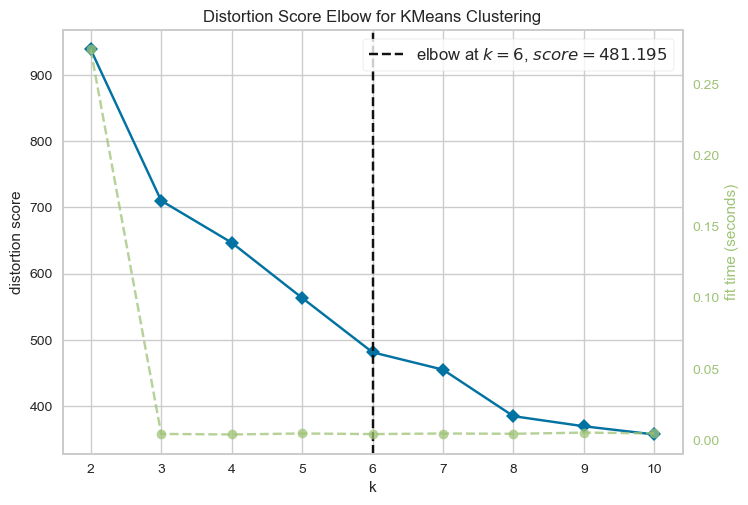

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
kelbow.fit(final_data)
kelbow.show()

**Although the above plot marks the elbow at K=6 but we can see a significant drop in Distrotion Score from K=2 to K=3. As we increase the number of clusters it might become over fitted. So Lets Explore Sillhouette Visualizer to identify the correct number of Clusters or more generalized value of K**

Inference – Choosing Number of Clusters (K)

The Elbow plot shows a clear and sharp drop in distortion/WCSS from K=2 to K=3, after which the marginal gain diminishes. Although there is a secondary elbow around K=6, moving to higher K risks over-segmenting similar countries.

The Silhouette score remains reasonably good for K=3, with balanced cluster sizes and no major collapse in score. Some misclassification is expected in real socio-economic data, but overall structure looks stable.

Combining both methods, K=3 offers the best trade-off between model simplicity, interpretability, and cluster quality, so we proceed with 3 clusters.

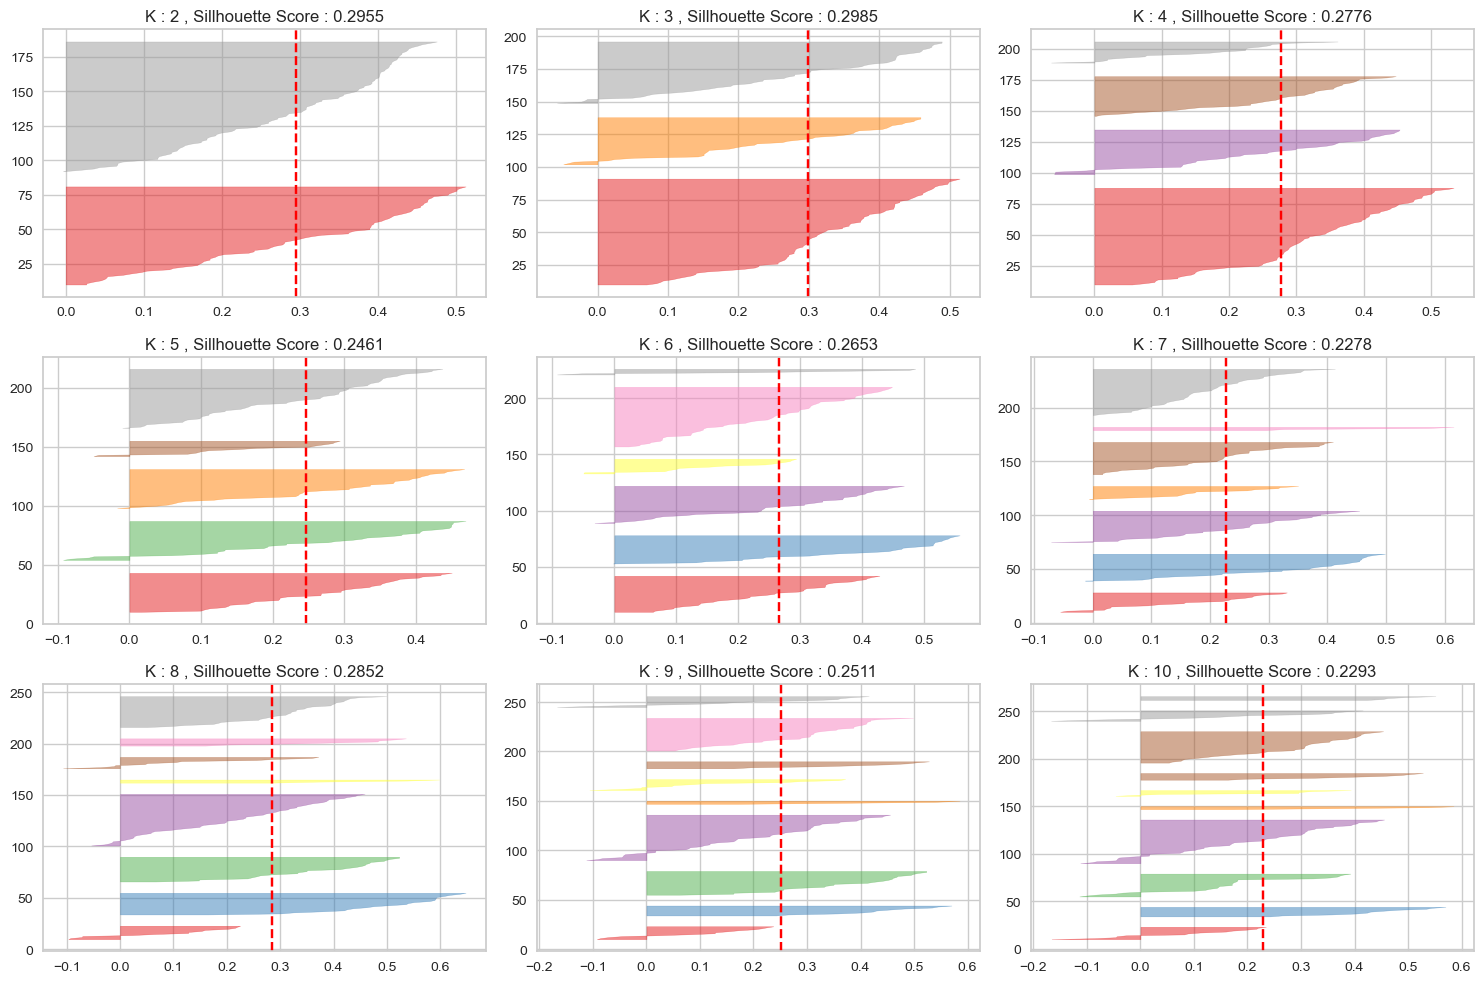

In [ ]:
t = 1
plt.figure(figsize=(15,10))
for i in range(2,11):
    plt.subplot(3,3,t)
    model = KMeans(n_clusters=i,random_state=2)
    sil_viz = SilhouetteVisualizer(model)
    sil_viz.fit(final_data)
    plt.title(f'K : {i} , Sillhouette Score : {round(sil_viz.silhouette_score_,4)}')
    t+=1
plt.tight_layout()
plt.show()

*After Analyzing Elbow Plot and Sillhouette Visualizer lets go with K=3. Although there are few datapoints that have been misclassified but we can see no drop in Silhouette score and there is good enough data in every cluster. Also from k-elbow plot significant drop in WCSS(Distortion Score) was observed from k = 2 to k=3.*

In [28]:
# Lets fit our final model
final_kmeans = KMeans(n_clusters=3,random_state=2)

In [29]:
labels = final_kmeans.fit_predict(final_data)

In [30]:
# Lets check the Sillhouette Score as well
print('Silhouette Score : ',silhouette_score(final_data,labels))

Silhouette Score :  0.29845782348296634


Inference – Cluster Quality

A Silhouette score of around 0.30 indicates moderate separation: clusters are reasonably distinct but not perfectly compact.

For noisy, real-world country-level socio-economic data, this is acceptable and suggests that the clusters capture meaningful, but not perfectly clean, groupings of countries.

This level of quality is sufficient for strategic decision-making (like aid prioritization) rather than fine-grained prediction.

In [31]:
labels

array([2, 0, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2,
       0, 1, 0, 2, 2, 0, 2, 1, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 1, 1,
       1, 0, 0, 0, 0, 2, 2, 0, 0, 1, 1, 2, 2, 0, 1, 2, 1, 0, 0, 2, 2, 0,
       2, 0, 1, 0, 0, 0, 2, 1, 1, 1, 0, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2,
       2, 0, 0, 1, 0, 2, 2, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0,
       1, 1, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 2, 0, 0,
       2, 1, 1, 1, 0, 2, 1, 1, 0, 0, 2, 0, 1, 1, 0, 2, 0, 2, 2, 0, 0, 0,
       0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2], dtype=int32)

In [32]:
# Lets put this data on PCA Data
final_data['Labels'] = labels
final_data.head(3)

,PC1,PC2,PC3,PC4,PC5,Labels
country,,,,,,
Afghanistan,-3.043637,-0.201155,0.951322,0.793445,-0.006800,2
Albania,0.423415,-0.371463,0.171749,-1.353581,0.088623,0
Algeria,-0.404684,-0.440312,-1.636775,-0.573008,0.397119,0


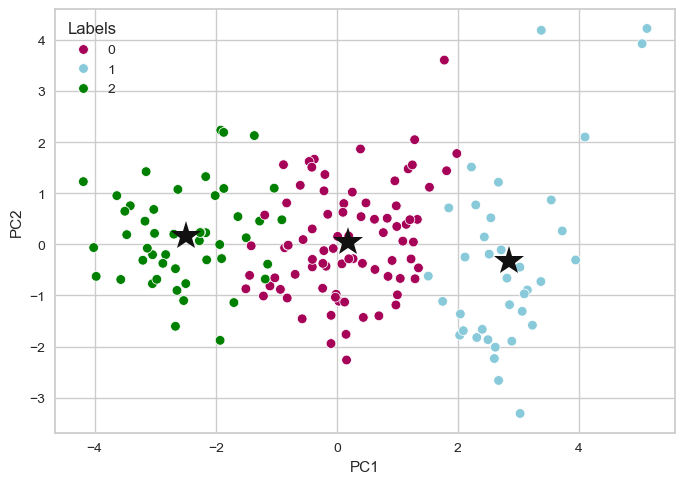

In [33]:
# Lets visualize the clusters
# In order to get the best Visualization lets choose PC1 and PC2 as they have maximum Variance
centroids = final_kmeans.cluster_centers_
centroids

sns.scatterplot(data=final_data,x='PC1',y='PC2',palette=['m','c','green'],hue='Labels')
for i in range(3):
    plt.plot(centroids[i][0],centroids[i][1],marker='*',ms = 22,color ='k')

plt.show()

Inference – Cluster Structure in PCA Space

The plot shows three distinct clusters of countries in the PC1–PC2 space, with clear centroids representing typical profiles of each group.

One cluster lies towards high PC1 / high PC2, representing countries with strong economic indicators, high life expectancy, low mortality, and lower fertility (likely developed nations).

Another cluster is concentrated in the negative PC1 / moderate PC2 region, reflecting very weak economic performance and poor health outcomes (underdeveloped nations).

The intermediate cluster sits between these two, representing developing countries that perform better than the poorest group but still lag behind the richest one.

This visual confirms that PCA followed by K-means has successfully grouped countries into meaningfully separated development levels.

## BUSINESS INTERPRETATION

In [34]:
data

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.44,56.2,5.82,553.0
Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.3,1.65,4090.0
Algeria,27.3,38.4,4.17,31.4,12900.0,16.10,76.5,2.89,4460.0
Angola,119.0,62.3,2.85,42.9,5900.0,22.40,60.1,6.16,3530.0
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100.0,1.44,76.8,2.13,12200.0
...,...,...,...,...,...,...,...,...,...
Vanuatu,29.2,46.6,5.25,52.7,2950.0,2.62,63.0,3.50,2970.0
Venezuela,17.1,28.5,4.91,17.6,16500.0,33.10,75.4,2.47,13500.0
Vietnam,23.3,72.0,6.84,80.2,4490.0,12.10,73.1,1.95,1310.0


In [35]:
# to have business understanding lets put the labels on the original dataset
data['Labels'] = labels
data.head

<bound method NDFrame.head of                      child_mort  exports  health  imports   income  inflation  \
country                                                                         
Afghanistan                90.2     10.0    7.58     44.9   1610.0       9.44   
Albania                    16.6     28.0    6.55     48.6   9930.0       4.49   
Algeria                    27.3     38.4    4.17     31.4  12900.0      16.10   
Angola                    119.0     62.3    2.85     42.9   5900.0      22.40   
Antigua and Barbuda        10.3     45.5    6.03     58.9  19100.0       1.44   
...                         ...      ...     ...      ...      ...        ...   
Vanuatu                    29.2     46.6    5.25     52.7   2950.0       2.62   
Venezuela                  17.1     28.5    4.91     17.6  16500.0      33.10   
Vietnam                    23.3     72.0    6.84     80.2   4490.0      12.10   
Yemen                      56.3     30.0    5.18     34.4   4480.0      23.60  

In [36]:
# to check what does label 0,1,2 means or reprents we will group the data by the labels and take the mean
data.groupby(by='Labels').mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
Labels,,,,,,,,,
0,21.508537,40.797317,6.231951,48.097561,12281.097561,7.474744,72.875610,2.311707,6291.146341
1,5.237838,53.575000,8.780270,49.129054,42690.878378,2.588432,79.956757,1.755676,36905.405405
2,92.131771,28.546229,6.296458,41.443040,3937.770833,10.438854,59.438542,4.953958,1902.916667


Inference – Interpreting Clusters (Development Levels)

Cluster 2 (later mapped to UnderDeveloped)

Very high child mortality (~92), high fertility (~4.95), low life expectancy (~59 years).

Low income (~$4k) and low gdpp (~$1.9k), with relatively high inflation (~10.4).

This describes countries that struggle simultaneously on economic, health and demographic fronts → the most vulnerable group.

Cluster 1 (later mapped to Developed)

Very low child mortality (~5), low fertility (~1.75) and highest life expectancy (~80 years).

Highest income (~$42k) and highest gdpp (~$37k), with relatively low inflation.

These are highly developed countries with strong economies and excellent health outcomes.

Cluster 0 (later mapped to Developing)

Intermediate values: moderate child mortality (~22), fertility (~2.3) and life expectancy (~73).

Income (~$12k) and gdpp (~$6.3k) are significantly better than the underdeveloped group but far below the developed group.

These countries are in transition – they have made progress but still face gaps in income, health investment and GDP.

Hence, the three clusters naturally align with Underdeveloped, Developing, and Developed country profiles.

In [37]:
# Interpretation : 
# after studying the above data we can conclude that countries that have been assigned label 2 or belong to cluster 2 can be called 
# Underdeveloped countries : because the are performing poor in most of the economic factors
# while Cluster 1 are developed Countries
# Countries belonging to cluster 0 are doing average in most of the factors but struggling with some economic factors like
# Gdpp, income and expenditure on health so they can be classified as developing Countries

In [38]:
# Lets rename the labels
data['Labels'] = data['Labels'].map({0:'Developing',
                    1:'Developed',
                    2:'UnderDeveloped'})

In [39]:
data.head(3)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Labels
country,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.44,56.2,5.82,553.0,UnderDeveloped
Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.3,1.65,4090.0,Developing
Algeria,27.3,38.4,4.17,31.4,12900.0,16.10,76.5,2.89,4460.0,Developing


In [40]:
# lets See the countries under each labels
print('DEVELOPED :',data[data['Labels']=='Developed'].index)
print('DEVELOPING :',data[data['Labels']=='Developing'].index)
print('UNDERDEVELOPED :',data[data['Labels']=='UnderDeveloped'].index)

DEVELOPED : Index(['Australia', 'Austria', 'Bahamas', 'Bahrain', 'Belgium', 'Brunei',
       'Canada', 'Cyprus', 'Czech Republic', 'Denmark', 'Finland', 'France',
       'Germany', 'Greece', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Kuwait', 'Luxembourg', 'Malta', 'Netherlands', 'New Zealand', 'Norway',
       'Portugal', 'Qatar', 'Singapore', 'Slovak Republic', 'Slovenia',
       'South Korea', 'Spain', 'Sweden', 'Switzerland', 'United Arab Emirates',
       'United Kingdom', 'United States'],
      dtype='object', name='country')
DEVELOPING : Index(['Albania', 'Algeria', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Azerbaijan', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cambodia',
       'Cape Verde', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia',
       'Fiji', 'Georgia', 'Grenada', 'Guatemala', 

Inference – Country Groupings

The Developed cluster includes North American, Western European and rich Asian and Middle-Eastern countries (e.g., USA, UK, Germany, Japan, Australia, Gulf states), which matches real-world expectations.

The UnderDeveloped cluster largely consists of Sub-Saharan African countries and a few low-income Asian nations, which are historically known to have high poverty and weaker health systems.

The Developing cluster includes large emerging economies (e.g., India, Brazil, China) and many middle-income countries from Asia, Latin America and Eastern Europe.

This geographic distribution increases confidence that the clustering is realistic and interpretable in a policy context.

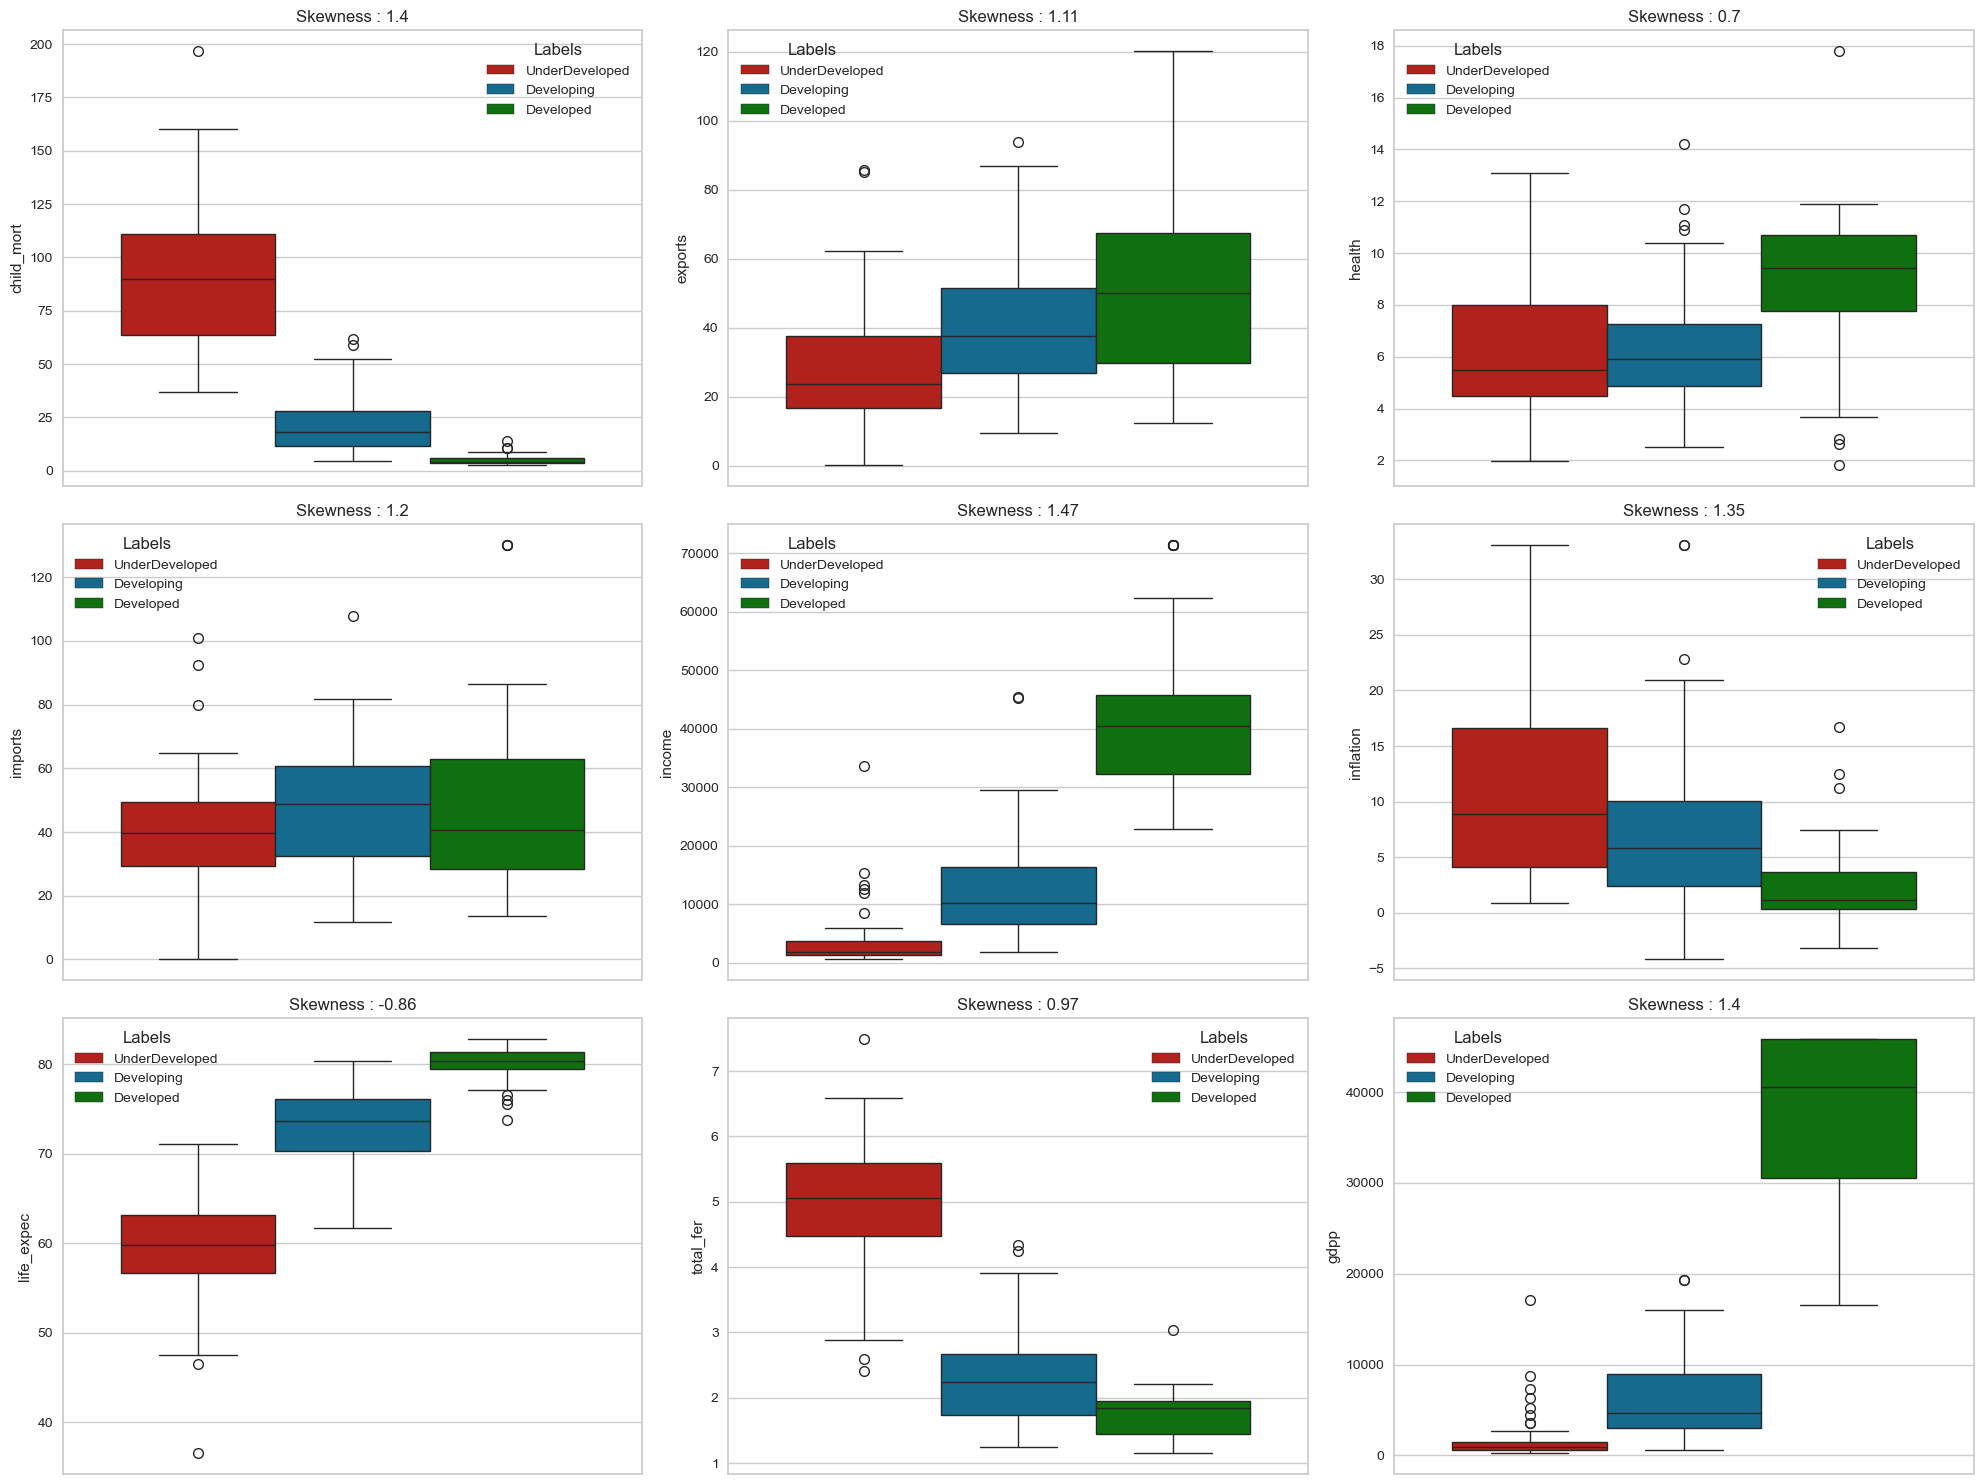

In [41]:
# Lets Visualize the Labels
t=1
plt.figure(figsize=(20,15))
for i in data.columns:
    if i !='Labels':
        plt.subplot(3,3,t)
        sns.boxplot(data=data,y=i,hue = 'Labels',palette=['r','b','green'])
        plt.title(f'Skewness : {round(data[i].skew(),2)}')
        t+=1
plt.tight_layout()
plt.show()

Inference – Comparing Clusters Across Indicators

For child mortality and total fertility, the UnderDeveloped group consistently has the highest medians, while the Developed group has the lowest, confirming stark differences in basic health outcomes.

For income and gdpp, the Developed group sits far above the other two clusters, with the UnderDeveloped group at the bottom and Developing in the middle.

Life expectancy is highest in the Developed cluster, moderate in Developing, and lowest in UnderDeveloped, mirroring the mortality patterns.

Health expenditure (as % of GDP) and trade variables (exports/imports) also show that developing and developed countries generally invest and trade more than underdeveloped ones.

Overall, these boxplots reinforce that the clusters are monotonic in development level: moving from UnderDeveloped → Developing → Developed improves almost every socio-economic and health indicator.

In [42]:
# lets show this data on the World map
# World Map
px.choropleth(data_frame=data,locationmode='country names', locations=data.index,color='Labels',color_discrete_map={'UnderDeveloped':'red',
                                                                                                                   'Developing':'blue',
                                                                                                                   'Developed':'green'})

Business Interpretation – Geographic Pattern of Need

The red (UnderDeveloped) countries are heavily concentrated in Sub-Saharan Africa, with some representation in South Asia and a few in other regions. These are the regions where HELP International is likely to find highest humanitarian need.

Blue (Developing) countries span Asia, Latin America, Eastern Europe and parts of the Middle East, indicating they are progressing but still require targeted support in health and economic reforms.

Green (Developed) countries are mostly in North America, Western Europe, East Asia and the richer Gulf states, where basic needs are already largely met; these countries are more potential donors/partners than aid recipients.

Mapping clusters on the world map allows the CEO to visually prioritize regions for deploying the $10M budget, focusing primarily on the red cluster and then selectively on the most vulnerable blue-cluster countries.

# DEPLOYMENT

In [46]:
input_data = data.iloc[0,:-1].values
input_data

array([np.float64(90.2), np.float64(10.0), np.float64(7.58),
       np.float64(44.9), np.float64(1610.0), np.float64(9.44),
       np.float64(56.2), np.float64(5.82), np.float64(553.0)],
      dtype=object)

In [48]:
final_input_data = pipeline.transform([input_data])
final_input_data

array([[-3.04363665, -0.20115529,  0.95132235,  0.79344472, -0.00680001]])

In [50]:
# the above array are the PCA

In [52]:
final_kmeans.predict(final_input_data)[0]

np.int32(2)

In [54]:
# Lets create a joblib file  of pipeline
with open('pipeline.joblib','wb') as file:
    joblib.dump(pipeline,file)

In [55]:
# lets create joblib file of model
with open('model.joblib','wb') as file:
    joblib.dump(final_kmeans,file)

Overall Business Interpretation & Recommendations for HELP International

Using socio-economic and health indicators (child mortality, life expectancy, fertility, income, GDP per capita, trade, health expenditure and inflation), we have clustered 167 countries into three distinct development groups: UnderDeveloped, Developing and Developed.

The UnderDeveloped cluster is characterized by very high child mortality and fertility, low life expectancy, low income and GDP per capita, and relatively high inflation. These are the countries in deepest humanitarian distress and are primary candidates for the NGO’s aid.

The Developing cluster shows intermediate performance: improvements in health and income, but still significant gaps compared to the developed world. Aid here should be more strategic and project-based (e.g., strengthening health systems, education, or targeted poverty-reduction programs).

The Developed cluster has excellent health and economic indicators and does not require basic humanitarian aid. Instead, these countries can be considered partners, donors or advocates for HELP International, rather than beneficiaries.

Geographical analysis reveals that most UnderDeveloped countries are located in Sub-Saharan Africa and parts of South Asia, aligning with known hotspots of poverty, high child mortality and low life expectancy.

Given the CEO’s objective of allocating $10 million effectively:

A major share of the budget should be directed to the UnderDeveloped cluster, prioritizing countries with the worst combination of high mortality, low life expectancy and low income.

A smaller portion can be reserved for high-need Developing countries where targeted interventions can yield large marginal improvements (for example, countries with moderate income but still high child mortality or low health expenditure).

Developed nations should be engaged mainly for fund-raising, partnerships and policy advocacy, rather than direct financial aid.

From a data-science standpoint, the project delivers a transparent and interpretable segmentation of countries based on measurable indicators. From a business standpoint, it provides HELP International with a data-driven framework to prioritize countries, ensuring that limited funds are directed where they can save the most lives and create the greatest impact.